In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'
from classy import Class

sys.path.append('/home/joeadamo/Research/Software')
from pk_tools import pk_tools
sys.path.insert(1, '/home/joeadamo/Research')
from CovNet import CovNet, CovaPT

In [2]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 111000
N_test = int(N*0.1)
offset = int(N*0.9)
train_nuisance = False
train_cholesky = True
train_gaussian_only = True
train_T0_only = False
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-HighZ-NGC/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/Updated/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

if train_gaussian_only == True:  folder = "gaussian"
else: folder = "marg"
if train_cholesky == True: folder+= "-cholesky/"
else: folder+= "-full/"

net_dir_1 = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/gaussian-cholesky-float/"
#net_dir_2 = "/home/joeadamo/Research/CovNet/emulators/ngc_z3/gaussian-full/"

In [3]:
params_fid = np.array([0.11827,67.77,3.0447,1.9485,-0.5387, 0.1, 0., 0., 500, 0])
params_best = np.array([69.21, 0.1150, 2.8945 / 3.0447, 2.226, -1.605, 0.288])

# Data vector taken from https://fbeutler.github.io/hub/deconv_paper.html
pk_dict = pk_tools.read_power(BOSS_dir+"P_CMASS_North.dat" , combine_bins =10)
data_vector = np.concatenate([pk_dict["pk0"][:25], pk_dict["pk2"][:25]])

k = np.linspace(0.005, 0.3995, 400)

W = pk_tools.read_matrix(BOSS_dir+"W_CMASS_North.matrix")
M = pk_tools.read_matrix(BOSS_dir+"M_CMASS_North.matrix")

Analytic_Calc = CovaPT.Analytic_Covmat(0.61)
Pk_best = Analytic_Calc.Pk_CLASS_PT_2(params_best, k)
model_vector_fixed = np.matmul(W, np.matmul(M, Pk_best))
model_vector_fixed = np.concatenate([model_vector_fixed[0:25], model_vector_fixed[80:105]])

def get_model_vector(params, i, offset):
    """
    Loads the model vector from file if it exists, otherwise calculates it and saves to file
    """
    idx = i + offset
    data = np.load(training_dir+"CovA-"+f'{idx:05d}'+".npz")
    np.testing.assert_allclose(params, data["params"])
    try:
        model_vector = data["Pk"]
        assert len(model_vector) == 200
        #model_vector = np.matmul(W, np.matmul(M, model_vector))
        return np.concatenate([model_vector[0:25], model_vector[80:105]])
    except:
        Pk_galaxy = Analytic_Calc.Pk_CLASS_PT_2(params, k)
        model_vector = np.matmul(W, np.matmul(M, Pk_galaxy))
        C_G = data["C_G"]; C_T0 = data["C_T0"]; C_SSC = data["C_SSC"]
        np.savez(training_dir+"CovA-"+f'{idx:05d}'+".npz", params=data["params"], Pk=model_vector, C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)
        return np.concatenate([model_vector[0:25], model_vector[80:105]])

In [4]:
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_heatmap(params, data, label, extents, cmap, log_scale):
    names = ['omch2', 'H0', "As", "b1", "b2", "bG2", "chi_squared"]
    labels= [r'$\omega_{cdm}$', r"$H_0$", r"$A_s$", "$b1$", "$b2$", "$bG2$", label]
        
    params = params.copy()
    temp = params[:,1].copy()
    params[:,1] = params[:,0].copy()
    params[:,0] = temp
    fig, axs = plt.subplots(6,6, figsize=(14,14))
    for i in range(6):
        for j in range(6):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], data, 30)
                #axs[i][j].axhline(0, color="red")
                axs[i][j].plot(x, y)
                #axs[i][j].set_ylim(-0.3, 0.3)
                #axs[i][j].set_yscale("log")
            else:
                X, Y, Z = make_heatmap(params[:,j], params[:,i], data, 30)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.SymLogNorm(linthresh=1., vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                # if log_scale == True: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, alpha=0.8, cmap=cmap,
                #                                               norm=colors.SymLogNorm(vmin=extents[0], vmax=extents[1], linthresh=1))
                # else: img = axs[i][j].scatter(params[:,j], params[:,i], c=data, s=1, vmin=extents[0], vmax=extents[1], alpha=0.8, cmap=cmap)
            if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
            axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1] ,size=20)
    cbar.ax.tick_params(labelsize=15) 
    plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

In [5]:
# load the test set
t1 = time.time()
test_data     = CovNet.MatrixDataset(training_dir, N_test, offset, train_nuisance, train_cholesky, train_gaussian_only=train_gaussian_only)
#gaussian_data = CovNet.MatrixDataset(training_dir, N_test, offset, train_nuisance, train_cholesky, train_gaussian_only=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 6.36 s


In [6]:
# load the trained network
#net = CovNet.Network_Full(6, 100*100)
net = CovNet.Network_VAE(train_cholesky).to(CovNet.try_gpu());       net.eval()
encoder = CovNet.Block_Encoder().to(CovNet.try_gpu()); encoder.eval()
decoder = CovNet.Block_Decoder(train_cholesky).to(CovNet.try_gpu()); decoder.eval()
net_2 = CovNet.Network_Latent().to(CovNet.try_gpu())
net.load_state_dict(torch.load(net_dir_1+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir_1+'network-latent.params'))

Cov_Emulator_1 = CovNet.CovNet(net_dir_1, 50, True, train_nuisance)

final VAE validation loss = 15.173
final Latent network validation loss = 2.272


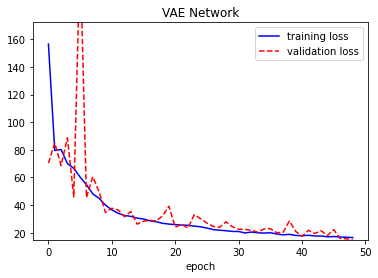

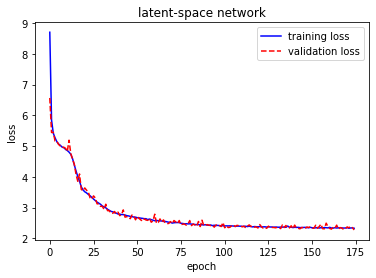

In [7]:
# visualize the training and validation loss
net_dir = net_dir_1
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-latent.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-latent.dat")

print("final VAE validation loss = {:0.3f}".format(torch.min(valid_loss[(valid_loss != 0)])))
print("final Latent network validation loss = {:0.3f}".format(torch.min(valid_loss_f[(valid_loss_f != 0)])))

epoch = range(len(train_loss[(train_loss != 0)]))
plt.title("VAE Network")
plt.plot(epoch, train_loss[(train_loss != 0)], color="blue", label="training loss")
plt.plot(epoch, valid_loss[(valid_loss != 0)], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylim(torch.min(train_loss[(train_loss != 0)])*0.9, train_loss[0]*1.1)
#plt.ylim(20, 100)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f[(train_loss_f != 0)]))
plt.figure()
plt.title("latent-space network")
plt.plot(epoch_f, train_loss_f[(train_loss_f != 0)], color="blue", label="training loss")
plt.plot(epoch_f, valid_loss_f[(train_loss_f != 0)], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend()

In [8]:
# try to visualize the latent feature space
features_decoder = torch.zeros(N_test, 6, device=CovNet.try_gpu())
features_latent = torch.zeros(N_test, 6, device=CovNet.try_gpu())

t1 = time.time()
for i in tqdm(range(N_test)):
    matrix = test_data[i][1]
    params = test_data[i][0]
    z, mu, log_var = encoder(matrix.view(1, 50, 50))
    features_decoder[i] = z
    features_latent[i] = net_2(params)
    
features_decoder = features_decoder.to("cpu").detach().numpy()
features_latent = features_latent.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

100%|███████████████████████████████████| 11100/11100 [00:06<00:00, 1691.58it/s]

Done!, took 0 minutes 7.09 seconds


6778 test matrices (61.063%) have latent-space distance errors less than 1


/home/joeadamo/virtual-enviornments/cov-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joeadamo/virtual-enviornments/cov-env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


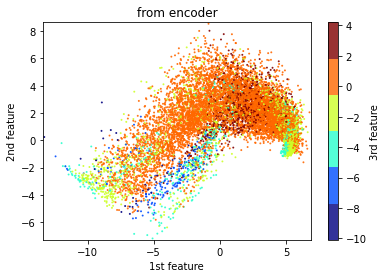

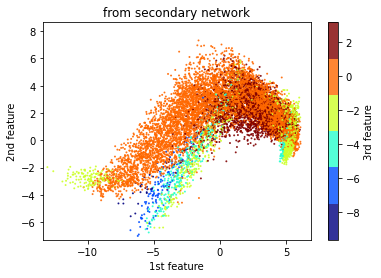

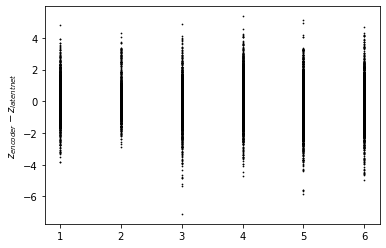

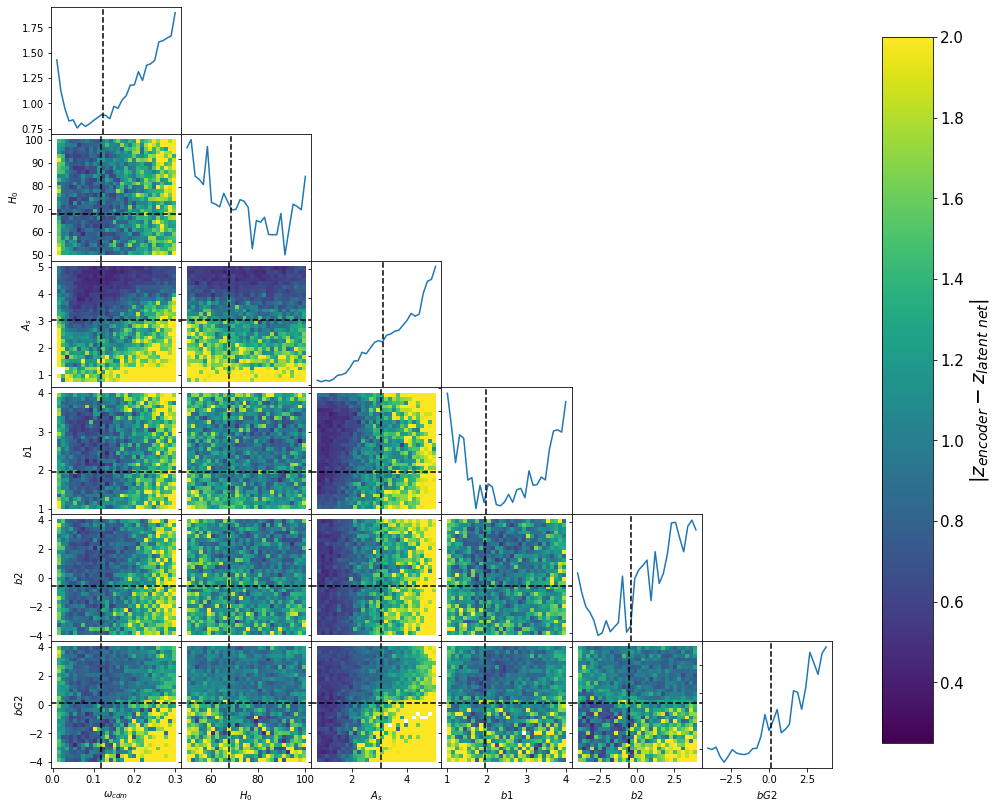

In [9]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

f1 = 1; f2 = 2; f3 = 3
plt.title("from encoder")
plt.scatter(features_decoder[:,f1], features_decoder[:,f2], cmap=cmap, c=features_decoder[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
plt.xlim(np.amin(features_decoder[:,f1])-0.1, np.amax(features_decoder[:,f1])+0.1)
plt.ylim(np.amin(features_decoder[:,f2])-0.1, np.amax(features_decoder[:,f2])+0.1)
cbar = plt.colorbar()
cbar.set_label("3rd feature")

plt.figure()
plt.title("from secondary network")
plt.scatter(features_latent[:,f1], features_latent[:,f2], cmap=cmap, c=features_latent[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
plt.xlim(np.amin(features_decoder[:,f1])-0.1, np.amax(features_decoder[:,f1])+0.1)
plt.ylim(np.amin(features_decoder[:,f2])-0.1, np.amax(features_decoder[:,f2])+0.1)
cbar = plt.colorbar()
cbar.set_label("3rd feature")

features_diff_sub = features_latent - features_decoder
plt.figure()
for i in range(6):
    plt.scatter(1+np.ones(N_test)*i, features_diff_sub[:,i], c="black", s=0.5)
plt.ylabel(r"$z_{encoder} - z_{latent net}$")


features_diff = np.linalg.norm(features_latent - features_decoder, axis=1)
num = len(features_diff[(features_diff < 1)])

print("{:0.0f} test matrices ({:0.3f}%) have latent-space distance errors less than 1".format(num, (100.*num)/N_test))

params = test_data[:][0].detach().numpy().copy()
params[:,2]*=3.0447
plot_heatmap(params, features_diff, r"$|z_{encoder} - z_{latent\ net}|$", [0.25, 2], "viridis", False)

In [10]:
# get a bunch of statistics from the test set and the matrices output by the emulator
loss_data_1 = np.zeros(N_test)
loss_data_2 = np.zeros(N_test)

loss_data_l1 = np.zeros(N_test)

det_actual = np.zeros(N_test)
det_reconstruct = np.zeros(N_test)
det_predict = np.zeros(N_test)

trace_actual = np.zeros(N_test)
trace_reconstruct = np.zeros(N_test)
trace_predict = np.zeros(N_test)

cond_actual = np.zeros(N_test)
#cond_reconstruct = np.zeros(N_test)
cond_predict = np.zeros(N_test)

num_NaN = 0
net.eval()
for i in tqdm(range(N_test)):
    params = test_data[i][0]; 
    C_actual = test_data[i][1]
    
    # get the loss that is internally calculated by the training algorithm
    C_reconstruct, mu, log_var = net(C_actual.view(1, 50, 50))
    C_predict = decoder(net_2(params).view(1,6)).view(50,50)
    if True in torch.isnan(C_predict): num_NaN += 1
    loss_data_1[i] = F.l1_loss(C_reconstruct.view(50,50), C_actual, reduction="sum")
    loss_data_2[i] = F.l1_loss(C_predict, C_actual, reduction="sum")
    
    C_reconstruct = CovNet.symmetric_exp(C_reconstruct).view(50,50)
    C_reconstruct = torch.matmul(C_reconstruct, torch.t(C_reconstruct)).detach().numpy()
    C_predict = CovNet.symmetric_exp(C_predict).view(50,50)
    C_predict = torch.matmul(C_predict, torch.t(C_predict)).detach().numpy()
    
    # now get the loss of the full covariance matrix (after un-doing data pre-processing
    C_actual = test_data.get_full_matrix(i)
    C_predict_1 = Cov_Emulator_1.get_covariance_matrix(params.detach().numpy())
    # sanity check that I'm using the emulator correctly
    assert np.allclose(C_predict, C_predict_1)
    
    loss_data_l1[i] = F.l1_loss(torch.from_numpy(C_actual), torch.from_numpy(C_predict_1), reduction="mean")
    
    det_actual[i] = np.linalg.slogdet(C_actual)[1]
    det_reconstruct[i] = np.linalg.slogdet(C_reconstruct)[1]
    det_predict[i] = np.linalg.slogdet(C_predict_1)[1]
    
    trace_actual[i] = np.trace(C_actual)
    trace_reconstruct[i] = np.trace(C_reconstruct)
    trace_predict[i] = np.trace(C_predict_1)
    
    cond_actual[i] = np.linalg.cond(C_actual)
    cond_predict[i] = np.linalg.cond(C_predict_1)
    
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_1), np.amax(loss_data_1), np.mean(loss_data_1)))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_2), np.amax(loss_data_2), np.mean(loss_data_2)))
print(num_NaN, "matrices have NaNs")

100%|████████████████████████████████████| 11100/11100 [00:50<00:00, 220.19it/s]

min loss: 3.347, max loss 237.012, avg loss: 15.196
min loss: 2.959, max loss 452.578, avg loss: 31.810
0 matrices have NaNs


loss error summary stats: mean = 31.810, median = 18.096, std = 41.419
2007 (18.08%) of matrices have loss better than 10!

trace error summary stats: mean = -0.142, median = -0.174, std = 0.355
2307 (20.78%) of matrices have trace errors better than 10%!

determinant error summary stats: mean = 0.000, median = -0.000, std = 0.020
5115 (46.08%) of matrices have log determinant errors better than 1%!


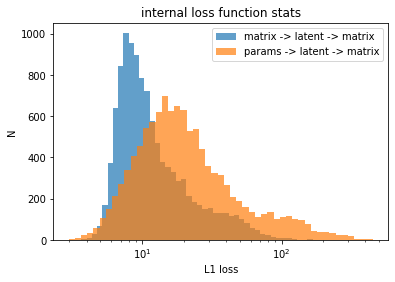

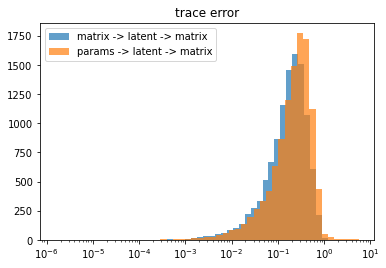

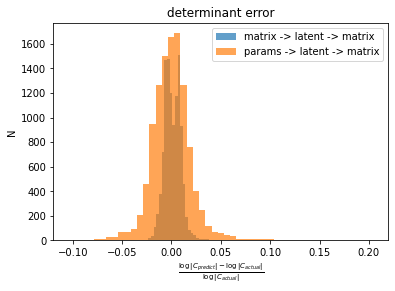

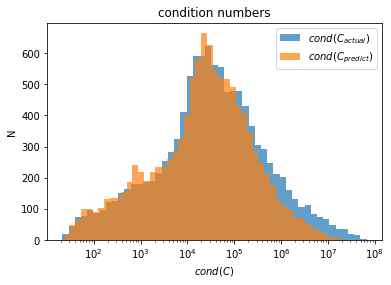

In [11]:
# these plots are mainly just for diagnostic purposes - not for showing other people
# because aparently they are too confusing
plt.title("internal loss function stats")
plt.hist(loss_data_1, alpha=0.7, label="matrix -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_1)), np.log10(np.amax(loss_data_1)), 50))
plt.hist(loss_data_2, alpha=0.7, label="params -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_2)), np.log10(np.amax(loss_data_2)), 50))
plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
plt.xscale("log")

trace_diff_1 = (trace_reconstruct - trace_actual) / trace_actual
trace_diff_2 = (trace_predict - trace_actual) / trace_actual

plt.figure()
plt.title("trace error")
plt.hist(abs(trace_diff_1), alpha=0.7, label="matrix -> latent -> matrix", bins=np.logspace(np.log10(np.amin(abs(trace_diff_1))), np.log10(np.amax(trace_diff_1)), 50))
plt.hist(abs(trace_diff_2), alpha=0.7, label="params -> latent -> matrix", bins=np.logspace(np.log10(np.amin(abs(trace_diff_2))), np.log10(np.amax(trace_diff_2)), 50))
plt.xscale("log")
plt.legend()

det_diff_1 = (det_reconstruct - det_actual) / det_actual
det_diff_2 = (det_predict - det_actual) / det_actual

num = len(loss_data_2[(abs(loss_data_2) <= 10)])
print("loss error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(loss_data_2), np.median(loss_data_2), np.std(loss_data_2)))
print("{:0d} ({:0.2f}%) of matrices have loss better than 10!".format(num, 100.*num/N_test))
num = len(trace_diff_2[(abs(trace_diff_2) <= 0.1)])
print("\ntrace error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(trace_diff_2), np.median(trace_diff_2), np.std(trace_diff_2)))
print("{:0d} ({:0.2f}%) of matrices have trace errors better than 10%!".format(num, 100.*num/N_test))
num = len(det_diff_2[(abs(det_diff_2) <= 0.01)])
print("\ndeterminant error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(det_diff_2), np.median(det_diff_2), np.std(det_diff_2)))
print("{:0d} ({:0.2f}%) of matrices have log determinant errors better than 1%!".format(num, 100.*num/N_test))

plt.figure()
plt.title("determinant error")
plt.hist(det_diff_1, alpha=0.7, label="matrix -> latent -> matrix", bins=np.linspace(np.amin(det_diff_1), np.amax(det_diff_1), 50))
plt.hist(det_diff_2, alpha=0.7, label="params -> latent -> matrix", bins=np.linspace(np.amin(det_diff_2), np.amax(det_diff_2), 50))
plt.xlabel(r"$\frac{\log{|C_{predict}|} - \log{|C_{actual}|}}{\log{|C_{actual}|}}$")
plt.ylabel("N")
plt.legend()

plt.figure()
plt.title("condition numbers")
plt.hist(cond_actual, alpha=0.7, label=r"$cond(C_{actual})$", bins=np.logspace(np.log10(np.amin(cond_actual)), np.log10(np.amax(cond_actual)), 50))
plt.hist(cond_predict, alpha=0.7, label=r"$cond(C_{predict})$", bins=np.logspace(np.log10(np.amin(cond_predict)), np.log10(np.amax(cond_predict)), 50))
plt.xlabel(r"$cond(C)$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

/home/joeadamo/virtual-enviornments/cov-env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


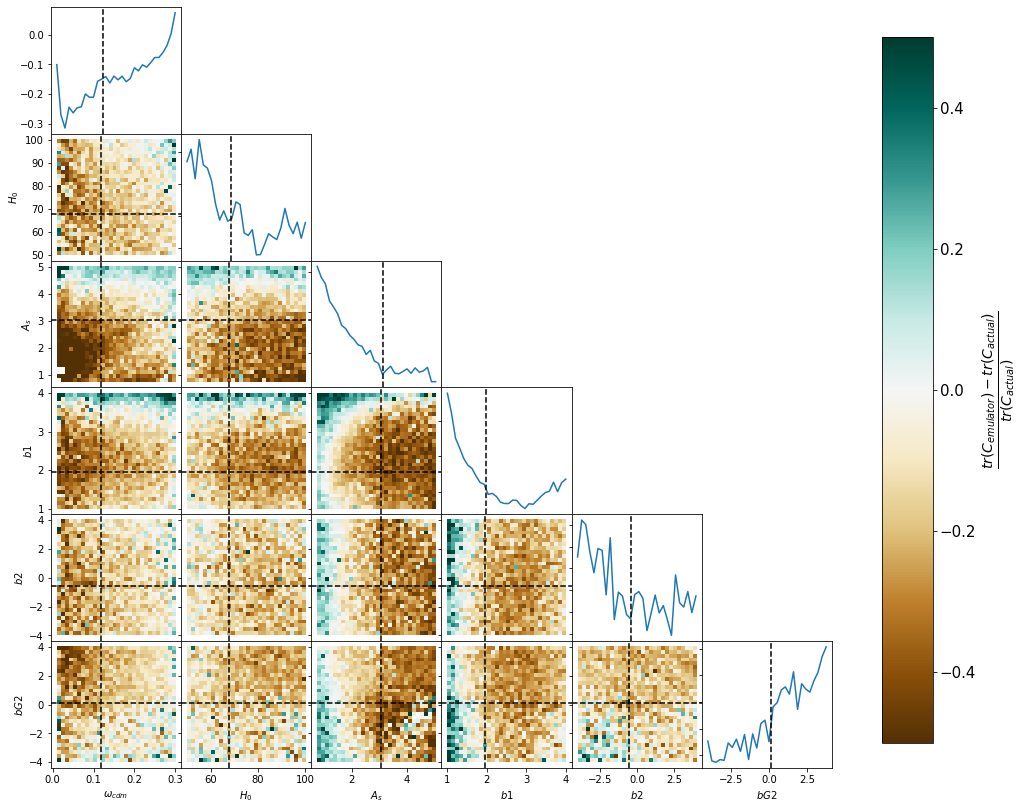

In [12]:
params = test_data[:][0].detach().numpy().copy()
params[:,2]*=3.0447
plot_heatmap(params, trace_diff_2, r"$\frac{tr(C_{emulator}) - tr(C_{actual})}{tr(C_{actual})}$", [-0.5, 0.5], "BrBG", False)

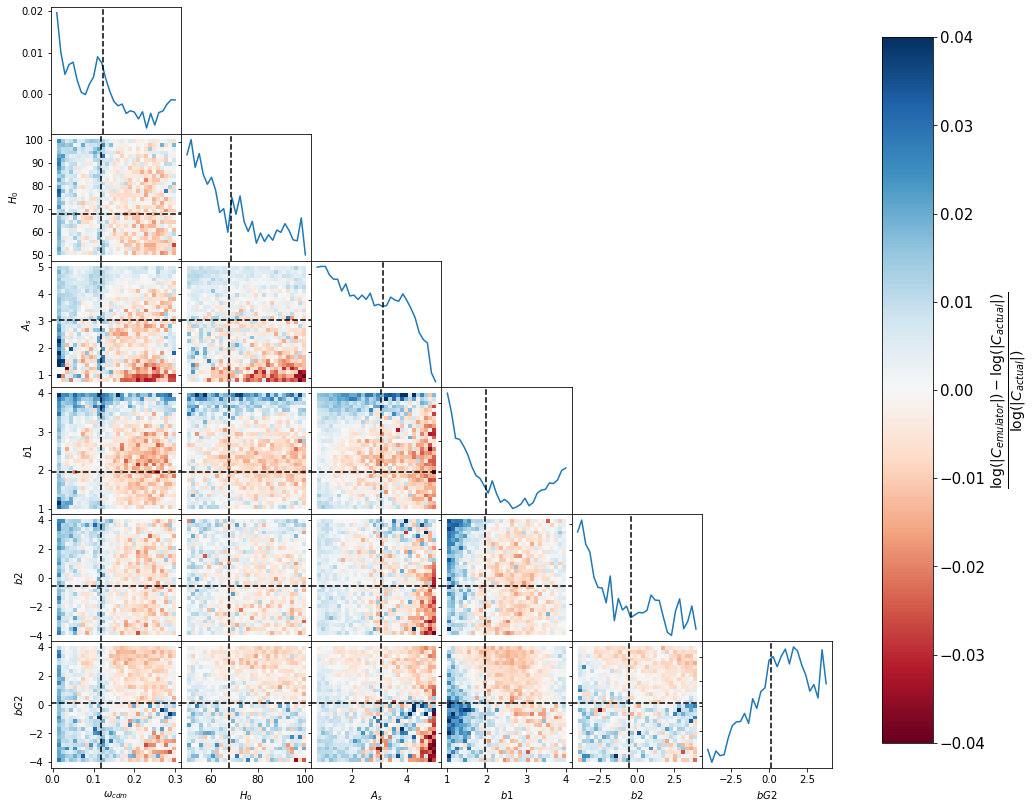

In [13]:
plot_heatmap(params, det_diff_2, r"$\frac{\log(|C_{emulator}|) - \log(|C_{actual}|)}{\log(|C_{actual}|)}$", [-0.04, 0.04], "RdBu", False)

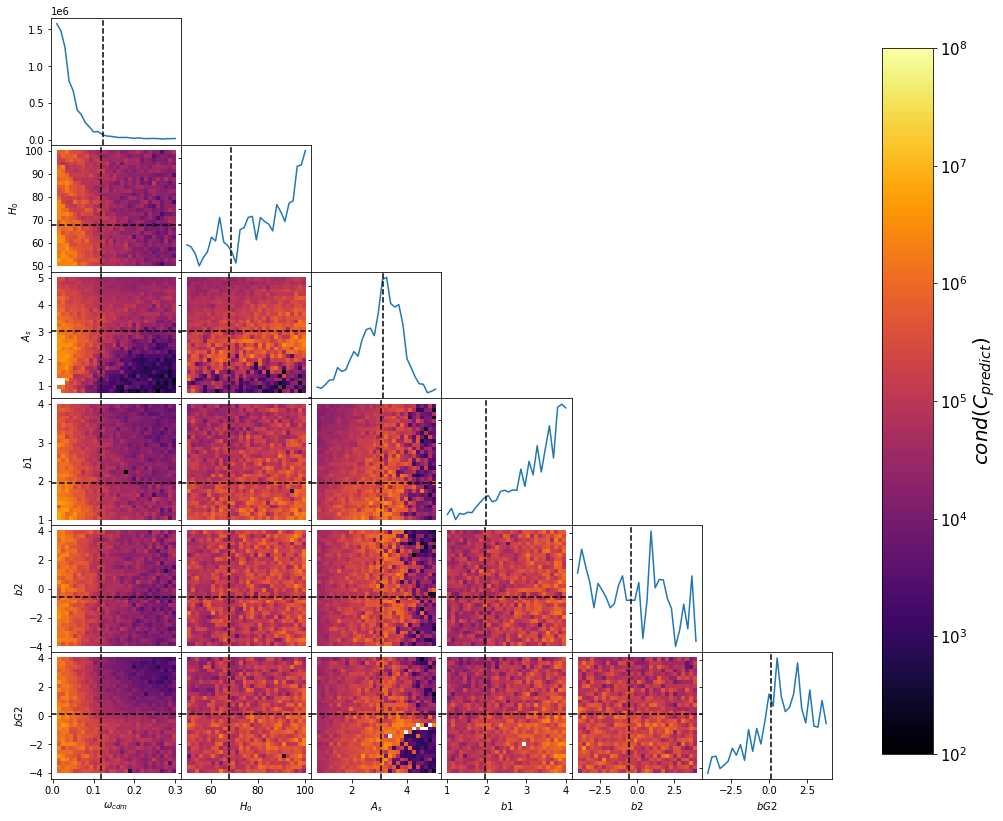

In [14]:
plot_heatmap(params, cond_predict, r"$cond(C_{predict})$", [1e2, 1e8], "inferno", True)

In [16]:
# # get the chi squared differences using this network
# # This cell takes ~ 2 hours to run the first time, 
# chi_squared_predict = np.zeros(N_test)
# chi_squared_actual = np.zeros(N_test)
# non_definete = []; avg_bad = 0
# x_fixed = data_vector - model_vector_fixed
# for i in tqdm(range(N_test)):
#     params = test_data[i][0].detach().numpy()
#     C_actual = test_data.get_full_matrix(i)
#     C_predict_1 = Cov_Emulator_1.get_covariance_matrix(params) 
    
#     #model_vector = get_model_vector(params, i, int(N*0.9))
    
#     P_predict_1 = np.linalg.inv(C_predict_1)
#     P_actual = np.linalg.inv(C_actual)
    
#     #x = data_vector - model_vector
#     chi_squared_actual[i] = np.matmul(x_fixed.T, np.matmul(P_actual, x_fixed))
#     chi_squared_predict[i] = np.matmul(x_fixed.T, np.matmul(P_predict_1, x_fixed))
    
# chi_squared_err = chi_squared_predict - chi_squared_actual
# chi_squared_err = chi_squared_err[(chi_squared_actual >= 0)]
# chi_squared_valid = chi_squared_actual[(chi_squared_actual >= 0)]

In [17]:
# chi_squared_rel_err = (chi_squared_predict - chi_squared_actual) / chi_squared_valid

# plt.figure()
# plt.hist(abs(chi_squared_rel_err), bins=np.logspace(np.log10(np.amin(abs(chi_squared_rel_err))), np.log10(np.amax(abs(chi_squared_rel_err))), 50))
# plt.xlabel(r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$")
# plt.ylabel("N")
# plt.xscale("log")

# num = len(chi_squared_rel_err[(abs(chi_squared_rel_err) <= 0.1)])
# print("'chi squared' error summary stats: mean = {:0.3f}, median = {:0.3f}, std = {:0.3f}".format(np.mean(chi_squared_rel_err), np.median(chi_squared_rel_err), np.std(chi_squared_rel_err)))
# print("{:0d} ({:0.2f}%) of matrices have chi squared errors better than 10%!".format(num, 100.*num/N_test))

# params = test_data[:][0].detach().numpy().copy()
# params[:,2]*=3.0447
# plot_heatmap(params, chi_squared_rel_err, r"$\frac{\chi_{predict}^2 - \chi_{actual}^2}{\chi_{actual}^2}$", 
#              [-0.6, 0.6], "PiYG", False)

In [18]:
#plot_heatmap(params, chi_squared_err, r"$\chi_{predict}^2 - \chi_{actual}^2$", [-1e4, 1e4], "viridis", True)

In [19]:
# # visualize the total (chi squared + log determinat) likelihood error at each point in parameter space
# # if the error depends on your location in parameter space, that's not good!

# lkl_actual = chi_squared_actual + det_actual
# lkl_predict = chi_squared_predict + det_predict

# lkl_error = lkl_predict - lkl_actual
# lkl_rel_error = lkl_error / lkl_actual
# print(np.amin(lkl_rel_error), np.amax(lkl_rel_error))

# #plot_heatmap(params, lkl_error, r"$(-2 \ln \mathcal{L}_{predict}) - (-2\ln \mathcal{L}_{actual})$", [-1e2, 1e5], "viridis", True)

# plot_heatmap(params, lkl_rel_error, r"$\frac{(-2 \ln \mathcal{L}_{predict}) - (-2\ln \mathcal{L}_{actual})}{(-2\ln \mathcal{L}_{actual})}$",
#                      [-0.1, 0.3], "viridis", False)

In [17]:
# do a PCA on the whole training set, treating each covariance matrix as a single realization
data_predict = np.zeros((N_test, 51*25))
data_actual  = np.zeros((N_test, 51*25))
data_random = np.zeros((N_test, 51*25))
rand_idx = np.random.randint(0, N_test)

min_val, max_val = 100, -100

for i in tqdm(range(N_test)):
    params = test_data[i][0]
    C_actual = test_data[i][1].view(1,50,50)
    C_random = torch.rand(1, 50, 50) * (9.79 + 9.94) - 9.94
    C_predict = decoder(net_2(params).view(1,6)).view(1, 50, 50)
    
    C_predict = CovNet.rearange_to_half(C_predict, 50).detach().numpy()
    C_actual = CovNet.rearange_to_half(C_actual, 50).detach().numpy()
    C_random = CovNet.rearange_to_half(C_random, 50).detach().numpy()
    
    data_predict[i] = C_predict.flatten()
    data_actual[i] = C_actual.flatten()
    data_random[i] = C_random.flatten()
    
    min_val = min(min_val, np.amin(C_actual))
    max_val = max(max_val, np.amax(C_actual))
    
print(min_val, max_val)
pca = PCA(n_components = 100)
# find the principal axes (basis vectors) of the testing set
pca.fit(data_actual)
# now project both the testing set and the prediced matrices set onto those basis vectors
components_predict = pca.transform(data_predict)
components_actual = pca.transform(data_actual)
components_random = pca.transform(data_random)

100%|███████████████████████████████████| 11100/11100 [00:08<00:00, 1259.93it/s]


-4.5388083 5.8378925


0.9612476936457398
(100,)


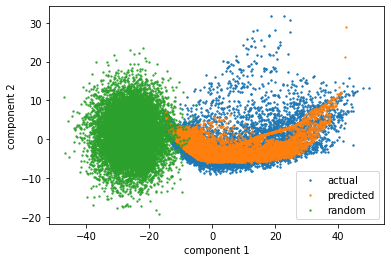

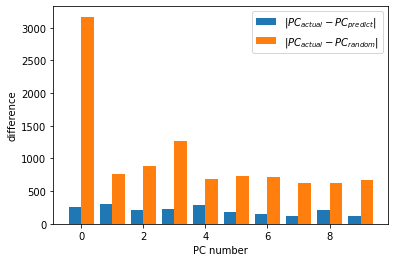

In [18]:
print(np.sum(pca.explained_variance_ratio_[:10]))
PCA_diff = np.linalg.norm(components_predict - components_actual, axis=0)
#PCA_diff = abs(np.sum(components_predict - components_actual, axis=0))
rand_diff = np.linalg.norm(components_random - components_actual, axis=0)
print(PCA_diff.shape)

plt.scatter(components_actual[:, 0], components_actual[:, 1], s=2, label="actual")
plt.scatter(components_predict[:, 0], components_predict[:, 1], s=2, alpha=0.8, label="predicted")
plt.scatter(components_random[:, 0], components_random[:, 1], s=2, alpha=0.8, label="random")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.legend()

plt.figure()
plt.bar(np.array(range(10))-0.2, PCA_diff[:10], width=0.4, label=r"|$PC_{actual} - PC_{predict}$|")
plt.bar(np.array(range(10))+0.2, rand_diff[:10], width=0.4, label=r"|$PC_{actual} - PC_{random}$|")
plt.xlabel("PC number")
plt.ylabel("difference")
plt.legend()
#plt.yscale("log")

### Tests on individual matrices

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indexes: 5399 2789


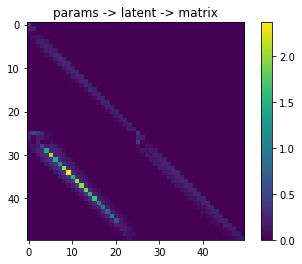

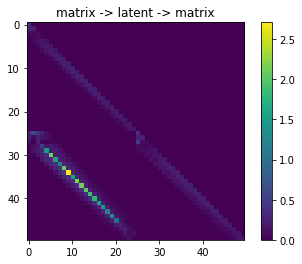

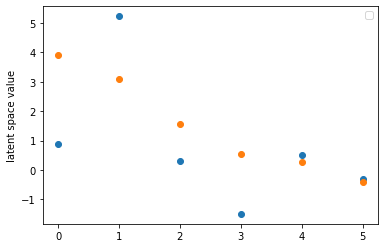

In [19]:
# Let's first confirm that seperate parameter imputs give different outputs
# if the resulting plot is all zeros, that may suggest posterior collapse of the network
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

cov_reconstruct1, mu, var = net(cov_actual1.view(1,50,50))
cov_reconstruct2, mu, var = net(cov_actual2.view(1,50,50))

features = net_2(params1); cov_predict1 = decoder(features.view(1,6)).view(50, 50).to("cpu").detach()
features_2 = net_2(params2); cov_predict2 = decoder(features_2.view(1,6)).view(50, 50).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.title("params -> latent -> matrix")
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

plt.figure()
plt.title("matrix -> latent -> matrix")
plt.imshow(abs(cov_reconstruct1 - cov_reconstruct2).view(50,50).detach().numpy())
cbar = plt.colorbar()

plt.figure()
plt.scatter(range(6), features.view(6).detach().numpy())
plt.scatter(range(6), features_2.view(6).detach().numpy())
plt.xticks([0,1,2,3,4,5])
plt.ylabel("latent space value")

reduction = 46.544, KL Divergence = 40.995
sample 4309, params: tensor([50.3783,  0.2721,  1.1507,  1.5935,  2.2090,  0.3669])
det(C) = 749.37, reconstruct = 538.276, actual = 540.828


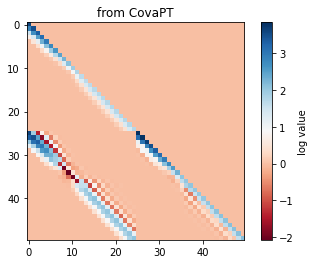

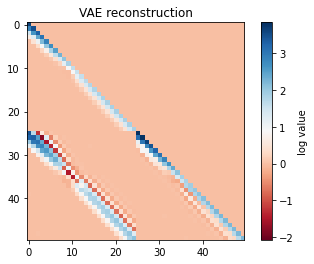

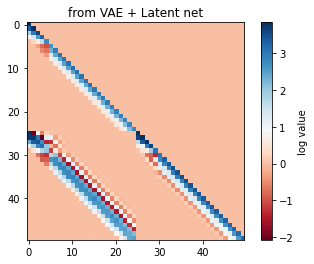

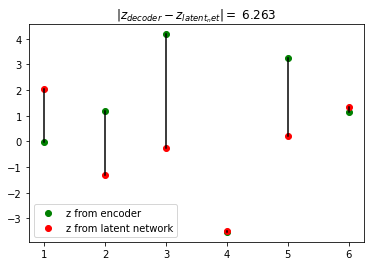

In [20]:
# Let's do some more detailed analysis on a random matrix from the test set
#idx = np.random.randint(0, N_test)
idx = np.argmax(det_diff_2)
#idx = np.argmax(chi_squared_err)

#idx = 0
params = test_data[idx][0]
# matrix from CovaPT
cov_actual = test_data[idx][1]
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,50,50)); cov_VAE = cov_VAE.view(50,50)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,6)).view(50, 50)
features_VAE, mu, log_var = encoder(cov_actual.view(1,50,50))

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("reduction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
#cov_actual = CovNet.symmetric_exp(cov_actual)
# cov_VAE = CovNet.symmetric_exp(cov_VAE)
# cov_predict = CovNet.symmetric_exp(cov_predict)

cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

#model_vector = get_model_vector(params.detach().numpy(), idx, int(N*0.9))
x = data_vector - model_vector_fixed
# chi_squared_pred = np.matmul(x.T, np.matmul(np.linalg.inv(CovNet.symmetric_exp(cov_predict).numpy()), x))
# chi_squared_act = np.matmul(x.T, np.matmul(np.linalg.inv(cov_actual.numpy()), x))

det_pred = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_predict).numpy())))
det_rec = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_VAE).numpy())))
det_act = 2*np.sum(np.log(np.diagonal(CovNet.symmetric_exp(cov_actual).numpy())))

print("det(C) = {:0.2f}, reconstruct = {:0.3f}, actual = {:0.3f}".format(det_pred, det_rec, det_act))
#print("Chi squared = {:0.3f}, actual = {:0.3f}".format(chi_squared_pred, chi_squared_act))

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + Latent net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

features_latent = features.detach().numpy()
features_VAE = features_VAE.detach().numpy()
norm = np.linalg.norm(features_VAE - features_latent)
norm_str = "{:0.3f}".format(norm)
plt.figure()
plt.title(r"$|z_{decoder} - z_{latent_net}| = $ " + norm_str)
plt.plot(np.vstack([range(1,7), range(1,7)]), np.vstack([features_latent, features_VAE]), c="black")
plt.scatter(range(1, 7), features_VAE, c="green", label="z from encoder")
plt.scatter(range(1, 7), features_latent, c="red",label="z from latent network")
plt.xticks([1,2,3,4,5,6])
plt.legend()

trace(C) = 2.180e+08 (actual = 2.337e+08
det(C) = 582.89, actual = 482.281


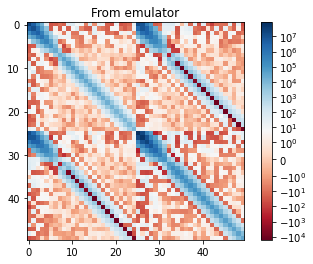

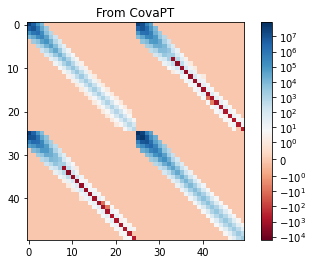

In [20]:
params = test_data[idx][0].detach().numpy()
C_actual = test_data.get_full_matrix(idx)
C_predict = Cov_Emulator_1.get_covariance_matrix(params)

trace_pred = np.trace(C_predict)
trace_act = np.trace(C_actual)

det_pred = np.linalg.slogdet(C_predict)[1]
det_act  = np.linalg.slogdet(C_actual)[1]

print("trace(C) = {:0.3e} (actual = {:0.3e}".format(trace_pred, trace_act))
print("det(C) = {:0.2f}, actual = {:0.3f}".format(det_pred, det_act))

plt.title("From emulator")
matrix = plt.imshow(C_predict, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_predict), vmax=np.amax(C_predict)))
plt.colorbar()

plt.figure()
plt.title("From CovaPT")
matrix = plt.imshow(C_actual, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(C_predict), vmax=np.amax(C_predict)))
plt.colorbar()

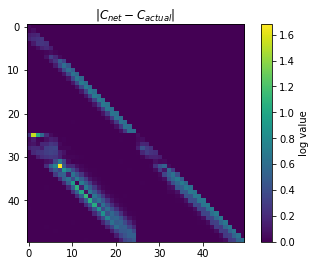

In [21]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

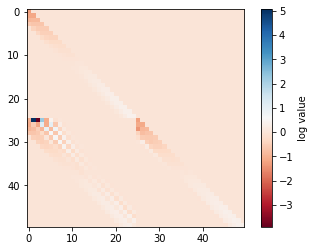

In [23]:
# test that 2 different parameter lsits give 2 different matrices
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)

params1 = test_data[idx1][0]
params2 = test_data[idx2][0]
# matrix from CovaPT
cov_actual1 = test_data[idx1][1]
cov_actual2 = test_data[idx2][1]

# matrix from parameters -> features and features -> matrix
cov_predict1 = decoder(net_2(params1).view(1,6)).view(50, 50)
cov_predict2 = decoder(net_2(params2).view(1,6)).view(50, 50)

cov_predict1 = cov_predict1.to("cpu").detach().numpy()
cov_predict2 = cov_predict2.to("cpu").detach().numpy()

plt.title("")
plt.imshow(cov_predict1 - cov_predict2, cmap="RdBu")#, vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

## Extra tests for debugging

tensor(667.8655) tensor(713.8621)


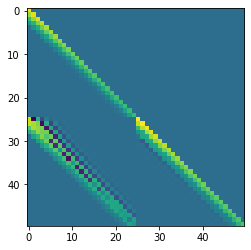

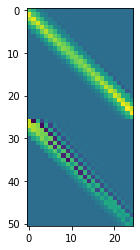

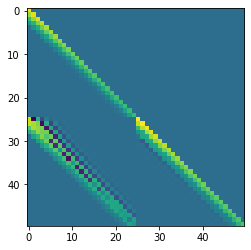

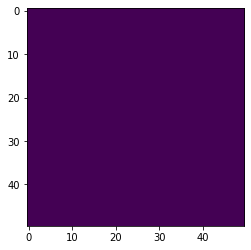

In [16]:
# test rearange to half / full code
idx1 = np.random.randint(0, N_test)

# matrix from CovaPT
cov_actual = test_data[idx1][1].view(1,50,50)

cov_half = CovNet.rearange_to_half(cov_actual, 50)

cov_full = CovNet.rearange_to_full(cov_half, 50, True)

det_half = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_half), dim1=1, dim2=2))) + \
           2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_half), offset=1, dim1=1, dim2=2)))
det_full = 2*torch.sum(torch.log(torch.diagonal(CovNet.symmetric_exp(cov_full), dim1=1, dim2=2)))

print(det_half, det_full)

plt.imshow(cov_actual.view(50,50).detach().numpy())

plt.figure()
plt.imshow(cov_half.view(51,25).detach().numpy())

plt.figure()
plt.imshow(cov_full.view(50,50).detach().numpy())

plt.figure()
plt.imshow((cov_full - cov_actual).view(50,50).detach().numpy())

In [27]:
params_test = torch.tensor([[70, 0.12, 1., 2., -1.4, 0.1],
                            [80, 0.2, 1.6, 3, -2, 1]])

bounds = torch.tensor([[50, 100],
                        [0.01, 0.3],
                        [0.25, 1.65],
                        [1, 4],
                        [-4, 4],
                        [-4, 4]])

print(bounds[:,0])
params_norm = (params_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])
print(params_norm)
print(bounds[:,1] - bounds[:,0])

tensor([ 5.0000e+01,  1.0000e-02,  2.5000e-01,  1.0000e+00, -4.0000e+00,
        -4.0000e+00])
tensor([[0.4000, 0.3793, 0.5357, 0.3333, 0.3250, 0.5125],
        [0.6000, 0.6552, 0.9643, 0.6667, 0.2500, 0.6250]])
tensor([50.0000,  0.2900,  1.4000,  3.0000,  8.0000,  8.0000])
